In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [17]:
def plot_sys(v,t):
        plot(t,v(t))
        xlabel('Quantity of water consumed')
        ylabel('Average rate of flow')

In [35]:
k_0 = 350#Carrying capacity 
x_0 =300
def logistic(q, k=k_0,r= 0.01):
    return k_0/(1+ exp(-r*(q-x_0)))

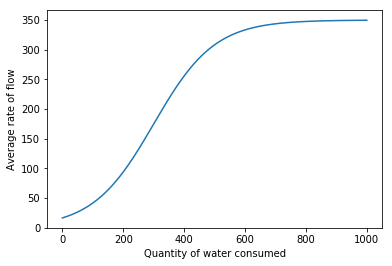

In [36]:
x = linspace(1,6, 10)
q= linspace(0,1000,10000)
plot_sys(logistic,q)

